## Проект

### 1. A/B–тестирование

#### 1.1 Условие

Задачей аналитика в команде является корректное проведение экспериментов. Для этого применяется метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### 1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:
* groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
* groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
* active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
* checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента.



In [187]:
import json
from urllib.parse import urlencode

import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import requests
import seaborn as sns
from scipy.stats import chi2, chi2_contingency

In [188]:
# Зададим параметры для визуализации графиков по умолчанию
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={'figure.figsize':(15,7)}
)

In [189]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
url_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
url_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
url_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'


In [190]:
# Функция для загрузки файла c Яндекс Диска без авторизации (при наличии публичных ссылок на папку и файл)
def download_file(url):
    final_url = base_url + urlencode({'public_key': url})
    response = requests.get(final_url)
    # Получаем загрузочную ссылку
    download_url = json.loads(response.text)['href']
    return download_url


In [191]:
# Загружаем файлы
groups = pd.read_csv(download_file(url_groups), sep=';')
active_studs = pd.read_csv(download_file(url_active_studs), sep=';')
checks = pd.read_csv(download_file(url_checks), sep=';')
groups_add = pd.read_csv(download_file(url_groups_add), sep=',')

Рассмотрим данные: размер датасетов, наличие пропусков и дублей, типы данных и количество уникальных значений.

In [192]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [193]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [194]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [195]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [196]:
# размеры датасетов
groups.shape, groups_add.shape, active_studs.shape, checks.shape

((74484, 2), (92, 2), (8341, 1), (541, 2))

In [197]:
# количество уникальных значений
groups.groupby('grp').id.nunique()

grp
A    14671
B    59813
Name: id, dtype: int64

In [198]:
groups_add.groupby('grp').id.nunique()

grp
A    22
B    70
Name: id, dtype: int64

In [199]:
active_studs.student_id.nunique()

8341

In [200]:
checks.student_id.nunique()

541

In [201]:
# узнаем типы данных
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [202]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [203]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [204]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [205]:
# проверим количество незаполненных значений во всех датафреймах
groups.isna().sum()


id     0
grp    0
dtype: int64

In [206]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [207]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [208]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [209]:
# проверим наличие дубликатов в датафреймах
groups.duplicated().sum()

0

In [210]:
checks.duplicated().sum() 

0

In [211]:
active_studs.duplicated().sum()

0

In [212]:
groups_add.duplicated().sum()

0

Видим, что в расматривамых данных пропуски и дубликаты отсутствуют, значения уникальны. Формат данных подходит для дальнейшего исследования. 

In [213]:
# объединим датафреймы с группами (основной и дополнительный) и переименуем колонку id
full_groups = pd.concat([groups, groups_add], ignore_index=True)
full_groups = full_groups.rename(columns={'id': 'student_id'})

In [214]:
# проверим размер нового датафрейма
full_groups.shape

(74576, 2)

In [215]:
full_groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  74576 non-null  int64 
 1   grp         74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [216]:
# проверим количество незаполненных значений в новом датафрейме
full_groups.isna().sum()

student_id    0
grp           0
dtype: int64

In [217]:
# проверим наличие дубликатов в новом датафрейме
full_groups.duplicated().sum()

0

In [218]:
# посмотрим на количество уникальных значений в группах
full_groups.groupby('grp').nunique()

,student_id
grp,
A,14693
B,59883


In [219]:
# объединим датафрейм с информацией об оплатах, пропуски заполним 0
groups_with_all_rev = full_groups.merge(checks, on='student_id', how='left').fillna(0)
groups_with_all_rev

,student_id,grp,rev
0,1489,B,0.0
1,1627,A,990.0
2,1768,B,0.0
3,1783,B,0.0
4,1794,A,0.0
...,...,...,...
74571,200247820,B,0.0
74572,201032527,B,0.0
74573,201067612,B,0.0
74574,201067653,B,0.0


In [220]:
# проверим наличие дубликатов в новом датафрейме
groups_with_all_rev.duplicated().sum()

0

In [221]:
# добавим колонку с пользователями, которые зашли/не зашли на платформу в дни проведения теста
groups_with_all_rev['is_active'] = groups_with_all_rev['student_id'].isin(active_studs['student_id'])
groups_with_all_rev

,student_id,grp,rev,is_active
0,1489,B,0.0,False
1,1627,A,990.0,True
2,1768,B,0.0,False
3,1783,B,0.0,False
4,1794,A,0.0,False
...,...,...,...,...
74571,200247820,B,0.0,False
74572,201032527,B,0.0,False
74573,201067612,B,0.0,False
74574,201067653,B,0.0,False


In [222]:
# посмотрим на количество пользователей, которые зашли или не зашли на платформу и совершили оплаты
groups_with_all_rev[groups_with_all_rev['rev'] != 0].groupby('is_active', as_index=False).agg({'student_id': 'nunique'})

,is_active,student_id
0,False,149
1,True,392


Как видим 392 человека зашли на платформу и совершили покупки, 149 человек оплатили каким-то другим способом. Исключаем их из исследования, так как они не входят в нашу целевую группу. 

In [223]:
# датафрейм с активными пользователями, которые зашли на платформу
df_active = groups_with_all_rev[groups_with_all_rev['is_active']]
df_active

,student_id,grp,rev,is_active
1,1627,A,990.0,True
10,2085,B,0.0,True
12,2215,B,0.0,True
43,3391,A,0.0,True
45,3401,B,0.0,True
...,...,...,...,...
74543,5760471,B,0.0,True
74545,5777081,B,0.0,True
74558,5870856,A,0.0,True
74561,5945085,B,0.0,True


In [224]:
# посмотрим на статистические показатели оплат активных пользователей
df_active.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


[Text(0, 0.5, 'Количество пользователей'), Text(0.5, 0, 'Выручка')]

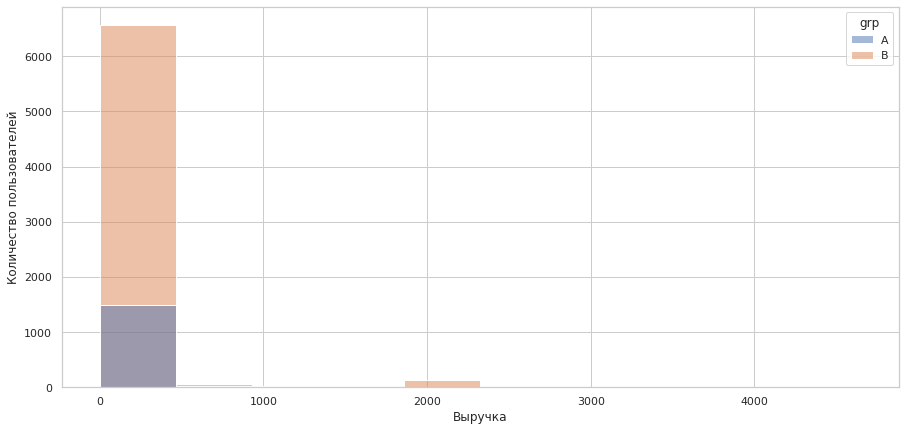

In [225]:
# визуализируем распределение по оплатам активных пользователей
ax = sns.histplot(x="rev", hue="grp", data=df_active, bins=10)
ax.set(xlabel='Выручка', ylabel='Количество пользователей')

Из графика видим, что большая чать пользователей в обеих группах не совершала оплат.

In [226]:
# датафрейм с активными пользователями, которые совершали оплаты
df_active_w_check = df_active.query('rev != 0')
df_active_w_check

,student_id,grp,rev,is_active
1,1627,A,990.0000,True
220,100300,B,990.0000,True
320,108270,B,290.0000,True
3779,264473,B,1900.0001,True
4187,274352,B,690.0000,True
...,...,...,...,...
74365,5645737,B,1900.0000,True
74381,5651566,B,1900.0000,True
74402,5662322,B,1900.0000,True
74452,5681918,B,1900.0000,True


In [227]:
# посмотрим на статистические показатели активных пользователей, которые совершали оплаты
df_active_w_check.groupby('grp').rev.describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


[Text(0, 0.5, 'Количество пользователей'), Text(0.5, 0, 'Выручка')]

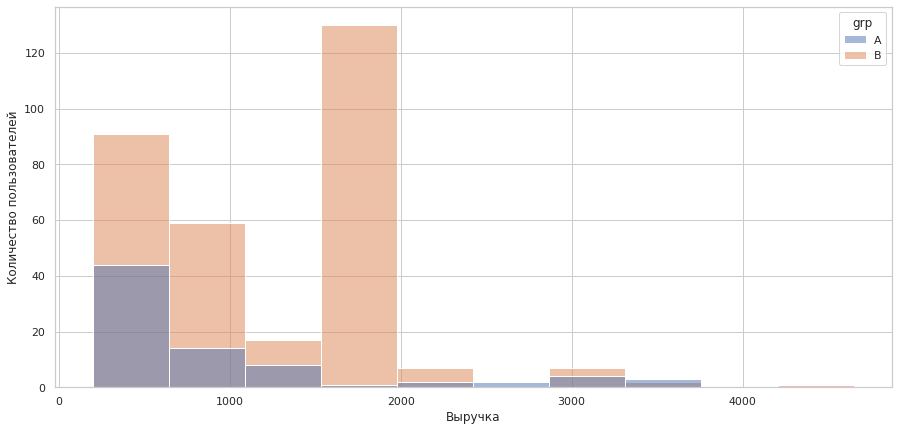

In [228]:
# визуализируем распределение по активным пользователям, которые совершали оплаты
ax = sns.histplot(x="rev", hue="grp", data=df_active_w_check, bins=10)
ax.set(xlabel='Выручка', ylabel='Количество пользователей')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text major ticklabel objects>)

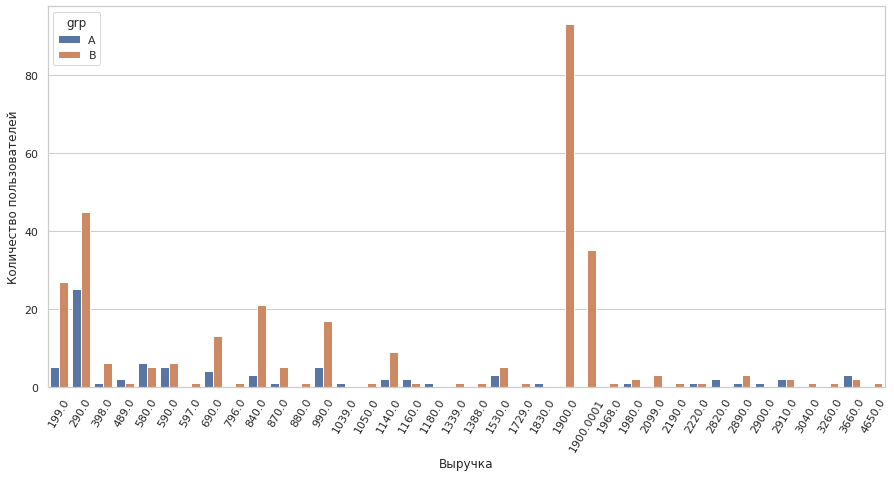

In [229]:
# визуализируем распределение по выручке
ax = sns.countplot(x="rev", hue="grp", data=df_active_w_check)
ax.set(xlabel='Выручка', ylabel='Количество пользователей')
plt.xticks(rotation=60)

Из графиков видим, что в тестовой группе значительно выросло число оплат на сумму 200, 290 и сильнее всего на сумму в районе 1900. В дальнейшем необходимо проверить не связано ли такое высокое число оплат с багом.

##### Выбор метрик для анализа
* CR (Conversion Rate) - конверсия в покупку. Рассчитывается как CR = (Количество целевых действий / Общее количество посетителей) * 100%. Поможет определить влияет ли новая механика оплаты на увеличение доли платящих пользователей. Основная метрика для оценки эффективности новой механики оплаты.;
* ARPU (average revenue per user) — средняя выручка на пользователя. Рассчитывается как ARPU = Доход / Количество клиентов. Поможет определить влияет ли новая механика оплаты на увеличение среднего дохода с пользователя;
* ARPPU (average revenue per paying user) — средняя выручка на платящего пользователя (совершившего хотя бы один платёж). Рассчитывается как ARPPU = Доход / Количество платящих клиентов. Поможет определить влияет ли новая механика оплаты на увеличение среднего дохода с платящего пользователя, т.е. с лояльных пользователей. Однако по имеющимся данным, пользователи делали оплаты только 1 раз, поэтому ARPPU равен среднему чеку.

In [230]:
# Расчет CR конверсии в покупку
cr_a = ((df_active_w_check.query('grp == "A"').rev.count() /
        df_active.query('grp == "A"').rev.count()) * 100).round(2)
cr_b = ((df_active_w_check.query('grp == "B"').rev.count() /
        df_active.query('grp == "B"').rev.count()) * 100).round(2)
print(f'СR для группы А: {cr_a}, СR для группы B: {cr_b}')

СR для группы А: 5.07, СR для группы B: 4.62


In [231]:
# Расчет ARPU средней выручки на пользователя
arpu_a = (df_active.query('grp == "A"').rev.sum() /
         df_active.query('grp == "A"').student_id.nunique()).round(2)
arpu_b = (df_active.query('grp == "B"').rev.sum() /
         df_active.query('grp == "B"').student_id.nunique()).round(2)
print(f'ARPU для группы А: {arpu_a}, СR для группы B: {arpu_b}')

ARPU для группы А: 47.35, СR для группы B: 58.06


In [232]:
# Расчет ARPPU средней выручки на платящего пользователя
arppu_a = (df_active_w_check.query('grp == "A"').rev.sum() /
         df_active_w_check.query('grp == "A"').student_id.nunique()).round(2)
arppu_b = (df_active_w_check.query('grp == "B"').rev.sum() /
         df_active_w_check.query('grp == "B"').student_id.nunique()).round(2)
print(f'ARPPU для группы А: {arppu_a}, СR для группы B: {arppu_b}')

ARPPU для группы А: 933.59, СR для группы B: 1257.88


CR ниже в тестовой группе. ARPU и ARPPU значительно выше в тестовой группе.

##### Проверка статистичесткой значимости полученых результатов
Для выбора подходящего статистического критерия и оценки результатов метрик, посмотрим на номальность распределений данных и дисперсии между контрольной и целевой группами.

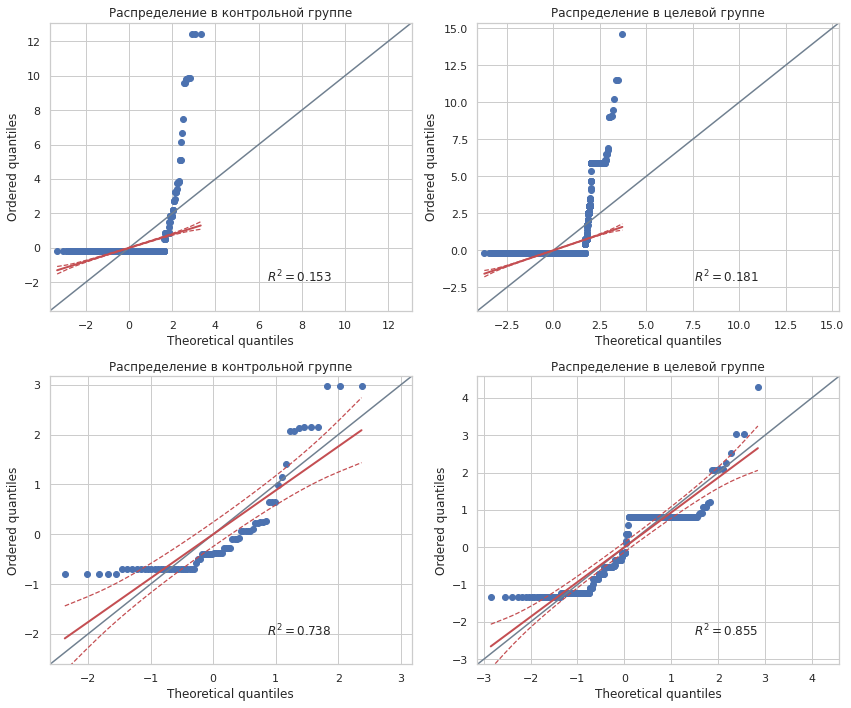

In [233]:
# визуализируем распределения с помощью QQ-графиков
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# для активыных пользователей
pg.qqplot(df_active.query('grp == "A"').rev, ax=axs[0, 0])
axs[0, 0].set_title('Распределение в контрольной группе')
pg.qqplot(df_active.query('grp == "B"').rev, ax=axs[0, 1])
axs[0, 1].set_title('Распределение в целевой группе')
# для активыных пользователей с оплатами
pg.qqplot(df_active_w_check.query('grp == "A"').rev, ax=axs[1, 0])
axs[1, 0].set_title('Распределение в контрольной группе')
pg.qqplot(df_active_w_check.query('grp == "B"').rev, ax=axs[1, 1])
axs[1, 1].set_title('Распределение в целевой группе')
plt.tight_layout()
plt.show()

In [234]:
# Также проверим нормальность распределений для активных пользователей с помощью теста Д'Агостино-Пирсона (выборкка > 5000)
pg.normality(data=df_active, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,2240.595797,0.0,False
B,7797.399212,0.0,False


In [235]:
# Проверим нормальность распределений для активных пользователяй c оплатой с помощью теста Шапиро-Уилка (выборка < 5000)
pg.normality(data=df_active_w_check, dv="rev", group="grp", method="shapiro")

,W,pval,normal
A,0.735324,1.498682e-10,False
B,0.854724,1.543702e-16,False


Статистические гипотезы у тестов нормальности следующие: H0 - ГС, из которой взята эта выборка, распределена нормально; H1 - ГС, из которой взята эта выборка, распределена не нормально. Поскольку p-value в наших случаях практически нулевое мы можем отвергнуть нулевую гипотезу, что говорит о ненормальности данных. Тот же результат показывают и QQ-графики.

In [236]:
# Проверим равенство дисперсий между группами для активных пользователей применив тест Левена (кассический тест равенства дисперсий)
pg.homoscedasticity(data=df_active, dv="rev", group="grp")

,W,pval,equal_var
levene,1.501461,0.220481,True


In [237]:
# Проверим равенство дисперсий между группами для активных пользователяй, которые совершали оплаты
pg.homoscedasticity(data=df_active_w_check, dv="rev", group="grp")

,W,pval,equal_var
levene,3.075682,0.080257,True


Статистические гипотезы у теста Левена: H0 - дисперсии в ГС не различаются, H1 - дисперсии в ГС различаются. В обоих наших тестах P-value больше 0.05, что не позволяет нам отклонить гипотезу и говорит о равенстве дисперсий.

#### Выбор стат.критериев:
* ARPU и ARPPU (количественные метрики) - данные не подчиняются нормальному распределению, но имеют одинаковые дисперсии и достаточно большие выборки, поэтому для сравнения можно использовать t-тест.
* CR (качественная метрика) для оценки используем Хи‑Квадрат.

In [238]:
# Гипотезы для оценки ARPU: H0 - средняя выручка в тестовой и контрольной группах равна, Н1 - средняя выручка в тестовой и контрольной группах не равна.    
ttest_arpu = pg.ttest(df_active.query('grp == "A"').rev, df_active.query('grp == "B"').rev)
ttest_arpu

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.286374,2416.748043,two-sided,0.198436,"[-27.04, 5.62]",0.034597,0.073,0.231965


In [239]:
print(f'Мы не можем отвергнуть нулевую гипотезу на уровне значимости 0.05.'
    f' Разница в средней выручке на пользователя не является значимой p-value: {ttest_arpu["p-val"].values[0]:.4f}')

Мы не можем отвергнуть нулевую гипотезу на уровне значимости 0.05. Разница в средней выручке на пользователя не является значимой p-value: 0.1984


In [240]:
# Гипотезы для оценки ARPPU: H0 - средняя выручка на платящего пользователя в тестовой и контрольной группах равна, Н1 - средняя выручка на платящего пользователя в тестовой и контрольной группах не равна.    
ttest_arppu = pg.ttest(df_active_w_check.query('grp == "A"').rev, df_active_w_check.query('grp == "B"').rev)
ttest_arppu

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


In [241]:
print(f'Мы можем отвергнуть нулевую гипотезу на уровне значимости 0.05.'
      
      f' Разница в средней выручке на на платящего пользователя является значимой p-value: {ttest_arppu["p-val"].values[0]:.4f}')

Мы можем отвергнуть нулевую гипотезу на уровне значимости 0.05. Разница в средней выручке на на платящего пользователя является значимой p-value: 0.0051


In [253]:
# Гипотезы для оценки CR: H0 - коверсия в тестовой и контрольной группах равна, Н1 - конверсия в тестовой и контрольной группах не равна.
ct = [
    [df_active_w_check.query('grp == "A"').shape[0],
     df_active.query('grp == "A"').shape[0] - df_active_w_check.query('grp == "A"').shape[0]],
    [df_active_w_check.query('grp == "B"').shape[0],
     df_active.query('grp == "B"').shape[0] - df_active_w_check.query('grp == "B"').shape[0]]
]
chi2, p, dof, expected = chi2_contingency(ct)
print(f'Хи-квадрат {chi2:.1f} p-value: {p:.4f}.')

Хи-квадрат 0.5 p-value: 0.4863.


In [243]:
if p <= 0.05:
    print('Отклоняем H0. Коверсия в тестовой и контрольной группах не равна')
else:
    print('Не отклоняем H0. Коверсия в тестовой и контрольной группах равна')

Не отклоняем H0. Коверсия в тестовой и контрольной группах равна


### Выводы

* ARPU средняя выручка на пользователя в группе A: 47.35, в группе B: 58.06, значимых различий не обнаружено (p-val = 0.198).
* ARPPU средняя выручка на платящего пользователя в группе A: 933.59, в группе B: 1257.88, есть значимые различия (p-val = 0.0051).
* CR конверсия в группе A: 5.07%, в группе B: 4.62%, значимых различий не обнаружено (p-val = 0.486).

Стоит ли запускать новую механику на всех пользователей?

Для запуска новой механики оплаты необходимы уточнения или проверка на баги. Как мы видим она не значимо повлияла на конверсию в покупку, но при этом заметно увеличила среднюю выручку у платящего пользователя. Возможно новая механика ценнее именно для платящих пользователей, например, в виде нового пакета услуг.

Рекомендации:
* Можно внедрить новую систему оплаты, если стратегия компании — максимизация выручки от платящих пользователей.
* Сегментировать пользователей: возможно, новая система работает лучше на лояльных клиентах/премиум клиентах.


### Задание 2. SQL
#### 2.1 Очень усердные ученики.
#### 2.1.1 Условие
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".
Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

#### 2.1.2 Задача
Дана таблица peas.
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.
#### 2.2 Оптимизация воронки
#### 2.2.1 Условие
Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
#### 2.2.2 Задача
Дана таблицы: peas, studs и final_project_check.
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
* ARPU 
* ARPAU 
* CR в покупку 
* СR активного пользователя в покупку 
* CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

#### Решение задачи 2.1.2: 
```query= """
SELECT COUNT(*)
    FROM (SELECT st_id 
        FROM peas
        GROUP BY st_id
        HAVING SUM(correct :: int) >= 20) as cnt_true_id """
```

#### Решение задачи 2.2.2:
```query = """
  -- Покупки по всем студентам 
WITH cte_all AS (
    SELECT 
        st_id, 
        SUM(money) AS total_money,
        COUNT(*) AS purchase_count,
        MAX(CASE WHEN subject = 'math' THEN 1 ELSE 0 END) AS with_math
    FROM final_project_check
    GROUP BY st_id
),```

  ```-- Активные пользователи (решили более 10 задач правильно)
cte_active_users AS (
    SELECT 
        st_id
    FROM peas
    GROUP BY st_id
    HAVING SUM(correct :: int) > 10
),```

 ``` -- Активные по математике (решившие ≥2 задачи по математике)
cte_active_math AS (
    SELECT 
        st_id
    FROM peas
    WHERE subject = 'math'
    GROUP BY st_id
    HAVING SUM(correct :: int) >= 2
),```

 ```-- Основной набор данных со всеми метками
cte_metrics AS (
    SELECT 
        s.st_id,
        s.test_grp,
        COALESCE(c.total_money, 0) AS revenue,
        CASE WHEN c.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_buyer,
        CASE WHEN a.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_active,
        CASE WHEN am.st_id IS NOT NULL THEN 1 ELSE 0 END AS is_active_math,
        COALESCE(c.bought_math, 0) AS with_math
    FROM studs s
    LEFT JOIN cte_all c ON s.st_id = c.st_id
    LEFT JOIN cte_active_users a ON s.st_id = a.st_id
    LEFT JOIN cte_active_math am ON s.st_id = am.st_id
)```
```-- Расчет метрик
SELECT
    test_grp,
    SUM(revenue)/ NULLIF(COUNT(st_id), 0) AS arpu,
    SUM(revenue) / NULLIF(SUM(is_active), 0) AS arpau,
    SUM(is_buyer)::numeric / COUNT(*) AS cr_all,
    SUM(CASE WHEN is_active = 1 THEN is_buyer ELSE 0 END)::numeric / NULLIF(SUM(is_active), 0) AS cr_active,
    SUM(CASE WHEN is_active_math = 1 THEN with_math ELSE 0 END)::numeric / NULLIF(SUM(is_active_math), 0) AS cr_math
    FROM cte_metrics
GROUP BY test_grp """
```


### Задание 3. Python
#### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [244]:
def add_file_and_update_metric(add_url):
    """
    Подгружает информацию из дополнительного файла groups_add.csv
    (заголовки могут отличаться) и пересчитывает метрики.
    """
    # Загрузка данных
    groups = pd.read_csv(download_file(url_groups), sep=';')    
    active_studs = pd.read_csv(download_file(url_active_studs), sep=';')
    checks = pd.read_csv(download_file(url_checks), sep=';')
    groups_add = pd.read_csv(download_file(add_url), sep=',')
    
    # Приведение названий столбцов
    groups.columns = ['student_id', 'grp']
    groups_add.columns = ['student_id', 'grp']
    
    # Объединение групп и датафреймов
    df = pd.concat([groups, groups_add], ignore_index=True)
    df = df.merge(checks, on='student_id', how='left').fillna(0)
    
    # Отметка активных пользователей
    df['is_active'] = df['student_id'].isin(active_studs['student_id'])
    df_active = df[df['is_active']]
    
    # Расчёт метрик
    metrics = []
    for group in df_active['grp'].unique():
        group_df = df_active[df_active['grp'] == group]
        group_with_rev = group_df[group_df['rev'] != 0]
        
        cr = round((len(group_with_rev) / len(group_df) * 100), 2)
        arpu = round(group_df['rev'].sum() / group_df['student_id'].nunique(), 2)
        arppu = round(group_with_rev['rev'].sum() / group_with_rev['student_id'].nunique(), 2)
        metrics.append({
            'group': group,
            'CR%': cr,
            'ARPU': arpu,
            'ARPPU': arppu
            })

    return pd.DataFrame(metrics)
    

In [245]:
add_url = url_groups_add
add_file_and_update_metric(add_url)

,group,CR%,ARPU,ARPPU
0,A,5.07,47.35,933.59
1,B,4.62,58.06,1257.88


In [246]:
def metrics_chart(df):
    """
    Строит графики barplot по полученным метрикам:
    CR, ARPU, ARPPU.
    """
    fig, axes = plt.subplots(nrows=1, ncols=3) 
    df.plot(x='group', y='CR%', kind='bar', ax=axes[0], legend=False, title='CR%')
    df.plot(x='group', y='ARPU', kind='bar', ax=axes[1], legend=False, title='ARPU')
    df.plot(x='group', y='ARPPU', kind='bar', ax=axes[2], legend=False, title='ARPPU') 
    for ax in axes:
        ax.set_xlabel("Группы")
        ax.set_xticklabels(df['group'], rotation=0)
    plt.show()

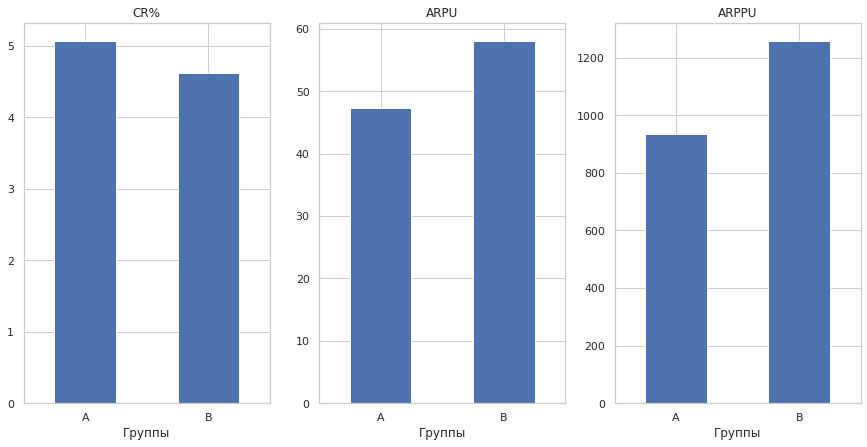

In [247]:
metrics_chart(add_file_and_update_metric(add_url))